In [2]:
import tensorflow as tf
from keras.models import load_model
import imageio
import os
from utils import *
from matplotlib.pyplot import imshow

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    # 这里好像有问题, 应该是containing (y1, x1, y2, x2)
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    """
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs

    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    max_box_scores = tf.reduce_max(box_scores, axis=-1)
    max_box_indices = tf.argmax(box_scores, axis=-1)

    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    mask = max_box_scores >= threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(max_box_scores, mask)
    boxes = tf.boolean_mask(boxes, mask)
    classes = tf.boolean_mask(max_box_indices, mask)

    
    return scores, boxes, classes

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    """
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    selected_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
 
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, selected_indices)
    boxes = tf.gather(boxes, selected_indices)
    classes = tf.gather(classes, selected_indices)

    
    return scores, boxes, classes

In [5]:
def yolo_eval(yolo_outputs, image_shape, max_boxes, score_threshold, iou_threshold):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    # Retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    
    return scores, boxes, classes

In [7]:
# 多目标检测
yolo_model = load_model("model_data/yolo.h5", compile=False)
class_names = read_classes("model_data/classes.txt")
anchors = read_anchors("model_data/anchors.txt")
# 单目标检测
# yolo_model = load_model("model_data/yolo_horse.h5", compile=False)
# class_names = ['horse']
# anchors = read_anchors("model_data/anchors.txt")

In [8]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
                                )                                                                 
          

In [9]:
def predict(image_file, max_boxes=10, score_threshold=0.6, iou_threshold=0.5):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size=(608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    re = yolo_model.predict(image_data)
    re = tf.convert_to_tensor(re)
    yolo_outputs = yolo_head(re, anchors, len(class_names))
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, tuple(map(float, image.size)), max_boxes, score_threshold, iou_threshold)


    # Print predictions info
    print('Found {} boxes for {}'.format(out_boxes.shape[0], image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.v2.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

1/1 [==============================] - 2s 2s/step
Found 2 boxes for horse.jpg
person 0.79 (389, 10) (566, 488)
horse 0.93 (91, 224) (936, 741)


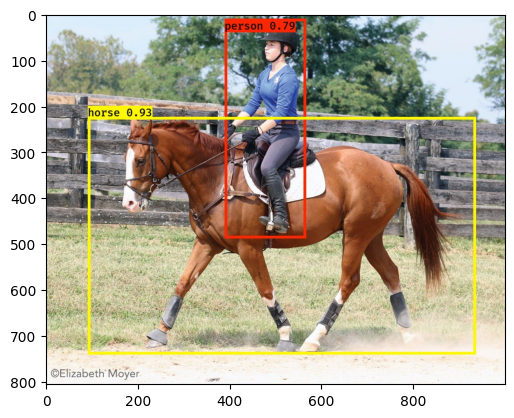

In [10]:
out_scores, out_boxes, out_classes = predict("horse.jpg", max_boxes=15, score_threshold=0.6, iou_threshold=0.1)